In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd drive/MyDrive

In [ ]:
def folder_download(folder_id):
  # authenticate
  from google.colab import auth
  auth.authenticate_user()
  # get folder_name
  from googleapiclient.discovery import build
  service = build('drive', 'v3')
  folder_name = service.files().get(fileId=folder_id).execute()['name']
  # import library and download
  !wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py
  from download import download_folder
  download_folder(service, folder_id, './', folder_name)
  return folder_name

In [ ]:
folder_download("1Nw8Ubo5IIFSzymeswGRF-gxICiGnwg9y")

MessageError: ignored

In [ ]:
!dir

!cp -r "PREPROCESS_DATA" "drive/MyDrive"

1Nw8Ubo5IIFSzymeswGRF-gxICiGnwg9y	       drive		sample_data
1Nw8Ubo5IIFSzymeswGRF-gxICiGnwg9y?usp=sharing  PREPROCESS_DATA
download.py				       __pycache__


In [ ]:
!gdown "https://drive.google.com/drive/folders/1Nw8Ubo5IIFSzymeswGRF-gxICiGnwg9y"

/usr/local/lib/python3.7/dist-packages/gdown/parse_url.py:39: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  url="https://drive.google.com/uc?id={}".format(file_id)
Downloading...
From: https://drive.google.com/drive/folders/1Nw8Ubo5IIFSzymeswGRF-gxICiGnwg9y
To: /content/1Nw8Ubo5IIFSzymeswGRF-gxICiGnwg9y
860kB [00:00, 65.4MB/s]


In [ ]:
!pip install pyworld
!pip install torch-summary
from torchsummary import summary
import torch.nn as nn 

     |████████████████████████████████| 212 kB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyworld: filename=pyworld-0.3.0-cp37-cp37m-linux_x86_64.whl size=609489 sha256=91a50afc724a3101b4cae02a8181c32905bc33887043a5e4f0e983bd0fcf1fb9
  Stored in directory: /root/.cache/pip/wheels/e7/7c/11/c775fffa0e1e7b05a6604b4323408a77f80fb4ab304d96b5c6
Successfully built pyworld


In [ ]:
def inver_MCCs(mcc_features,sr=22050,dim=36):
  fftlen = pyworld.get_cheaptrick_fft_size(sr)
  decoded_sp=pyworld.decode_spectral_envelope(mcc_features, sr,fftlen) # gives a spectogram
  return decoded_sp
 
def get_wav_from_spec(f0, decoded_sp,aperiodicity, sr=22050, frame_period=5):
  #get wav file 
  # decoded_sp=inver_MCCs(mcc_features)
  wav = pyworld.synthesize(f0, decoded_sp,aperiodicity, sr, frame_period)
  # Librosa could not save wav if not doing so
  wav = wav.astype(np.float32)
  return wav
 
def get_wav(f0, mcc_features,aperiodicity, sr=22050, frame_period=5):
  #get wav file 
  decoded_sp=inver_MCCs(mcc_features)
  wav = pyworld.synthesize(f0, decoded_sp,aperiodicity, sr, frame_period)
  # Librosa could not save wav if not doing so
  wav = wav.astype(np.float32)
  return wav
 
from IPython.display import Audio
from IPython.core.display import display
def play_audio(wav):
  display(Audio(wav,rate=22050))
 
def one_hot(source,to,speaker_list=["VCC2SF1","VCC2SF2","VCC2SM1","VCC2SM2"]):
  import numpy as np 
  len_=len(speaker_list)
  source=speaker_list.index(source)
  to=speaker_list.index(to)
  c=np.zeros([len_,len_])
  c[source,to]=1
  return c

In [ ]:
import torch 
import torch.nn as nn
# version 2
class con_batch_glu(nn.Module):
  def __init__(self,in_channels, out_channels, kernel_size, stride, padding, dilation=1, groups=1, bias=False, padding_mode='zeros'):
    super(con_batch_glu,self).__init__()
    self.architecture=nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups,bias, padding_mode),
        nn.InstanceNorm2d(num_features=out_channels,affine=True, track_running_stats=True),
    )
  
  def forward(self,x):
    x=self.architecture(x)
    x=nn.functional.glu(x,dim=1)
    return x

class decon_batch_glu(nn.Module):
  def __init__(self,in_channels, out_channels, kernel_size, stride, padding, output_padding=0, groups=1, bias=False, dilation=1, padding_mode='zeros'):
    super(decon_batch_glu,self).__init__()
    self.architecture=nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride,padding, output_padding, groups, bias, dilation, padding_mode),
        nn.InstanceNorm2d(num_features=out_channels,affine=True, track_running_stats=True),
    )
  
  def forward(self,x):
    x=self.architecture(x)
    x=nn.functional.glu(x,dim=1)
    return x


# version 2



class Discriminator(nn.Module):

  def __init__(self): 
    super(Discriminator,self).__init__()
    self.para=[[128,(3,9),(1,1),(1,4)],[64,(3,8),(1,2),(1, 3)],[32,(3,8),(1,2),(1, 3)],[16,(3,6),(1,2),(1, 2)]]

    in_channels=2
    i=0 #layer 1
    self.layer1=con_batch_glu(in_channels,*self.para[i])
    in_channels=(self.para[i][0])//2 +1

    i+=1
    self.layer2=con_batch_glu(in_channels,*self.para[i])
    in_channels=(self.para[i][0])//2 +1

    i+=1
    self.layer3=con_batch_glu(in_channels,*self.para[i])
    in_channels=(self.para[i][0])//2 +1
    i+=1
    self.layer4=con_batch_glu(in_channels,*self.para[i])
    in_channels=(self.para[i][0])//2 +1


    self.layer_con=nn.Sequential(con_batch_glu(in_channels=in_channels, out_channels=8, kernel_size=(6,5), stride=(3,4), padding=(0,0)),
                                 con_batch_glu(in_channels=4, out_channels=2, kernel_size=(5,4), stride=(2,3), padding=(0,0)),
                                 )

    # self.pool=nn.AvgPool2d(kernel_size=(1,64))
    

  def forward(self,x,c):
    c=c.view(c.shape[0],1,c.shape[1],c.shape[2]) # shape (nx1x4x4)

    c1=c.repeat(1,1,9,128) #shape [n , 4, 36, 512]
    x=torch.cat([x, c1], dim=1)
    x=self.layer1(x)

    c1=c.repeat(1,1,9,128) #shape [n , 4, 36, 512]
    x=torch.cat([x, c1], dim=1)
    x=self.layer2(x)

    c1=c.repeat(1,1,9,64) #shape [n , 4, 36, 256]
    x=torch.cat([x, c1], dim=1)
    x=self.layer3(x)

    c1=c.repeat(1,1,9,32) #shape [n , 4, 36, 32]
    x=torch.cat([x, c1], dim=1)
    x=self.layer4(x)

    c1=c.repeat(1,1,9,16)
    x=torch.cat([x, c1], dim=1)
    x=self.layer_con(x)

    x=torch.sigmoid(x)
    c1=c.repeat(1,1,1,1)
    x=x*c1
    # # x=self.pool(x)
    return x

summary(Discriminator(),[(1,36,512),(4,4)])



class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.para=[[128,(3,9),1,(1, 4)],[64,(4,8),(2,2),(1, 3)],[32,(4,8),(2,2),(1,3)],[16,(3,5),(1,1),(1,2)],[8,(4,5),(2,1),(1,2)]]

    layers=[]
    in_channels=1
    for i in range(len(self.para)):
      layers.append(con_batch_glu(in_channels,*self.para[i]))
      in_channels=self.para[i][0]//2
    
    self.para_1=[[64,(2,5),(2,1),(0, 2)],[128,(4,5),(2,1),(1, 2)],[64,(6,8),(2,2),(0, 3)],[32,(3,8),(1,2),(1, 3)]]

    i=0 #layer 1
    in_channels+=1
    self.layer1=decon_batch_glu(in_channels,*self.para_1[i])
    in_channels=(self.para_1[i][0])//2 +1
    i+=1

    self.layer2=decon_batch_glu(in_channels,*self.para_1[i])
    in_channels=(self.para_1[i][0])//2 +1
    i+=1

    self.layer3=decon_batch_glu(in_channels,*self.para_1[i])
    in_channels=(self.para_1[i][0])//2 +1
    i+=1

    self.layer4=decon_batch_glu(in_channels,*self.para_1[i])
    in_channels=(self.para_1[i][0])//2 +1
    i+=1
    
    self.architecture=nn.Sequential(*layers)
    
    self.decon=nn.ConvTranspose2d(in_channels, out_channels=1, kernel_size=(3, 9), stride=(1, 1), padding=(1,4) )

    
  def forward(self,x,c):
    x=self.architecture(x)
    c=c.view(c.shape[0],1,c.shape[1],c.shape[2]) # shape (nx1x4x4)

    c1=c.repeat(1,1,1,32) #shape [n , 1, 4,128]
    x=torch.cat([x, c1], dim=1)
    x=self.layer1(x)

    c1=c.repeat(1,1,2,32) #shape [n , 1, 9,128]
    x=torch.cat([x, c1], dim=1)
    x=self.layer2(x)

    c1=c.repeat(1,1,4,32) #shape [n , 1, 9,128]
    x=torch.cat([x, c1], dim=1)
    x=self.layer3(x)

    c1=c.repeat(1,1,9,64) #shape [n , 1,18,256]
    x=torch.cat([x, c1], dim=1)
    x=self.layer4(x)

    c1=c.repeat(1,1,9,128) #shape [n ,1,36,512]
    x=torch.cat([x, c1], dim=1)

    x=self.decon(x)

    return x

summary(Generator(),[(1,36,512),(4,4)])

Layer (type:depth-idx)                   Output Shape              Param #
├─con_batch_glu: 1-1                     [-1, 64, 36, 512]         --
|    └─Sequential: 2-1                   [-1, 128, 36, 512]        --
|    |    └─Conv2d: 3-1                  [-1, 128, 36, 512]        6,912
|    |    └─InstanceNorm2d: 3-2          [-1, 128, 36, 512]        256
├─con_batch_glu: 1-2                     [-1, 32, 36, 256]         --
|    └─Sequential: 2-2                   [-1, 64, 36, 256]         --
|    |    └─Conv2d: 3-3                  [-1, 64, 36, 256]         99,840
|    |    └─InstanceNorm2d: 3-4          [-1, 64, 36, 256]         128
├─con_batch_glu: 1-3                     [-1, 16, 36, 128]         --
|    └─Sequential: 2-3                   [-1, 32, 36, 128]         --
|    |    └─Conv2d: 3-5                  [-1, 32, 36, 128]         25,344
|    |    └─InstanceNorm2d: 3-6          [-1, 32, 36, 128]         64
├─con_batch_glu: 1-4                     [-1, 8, 36, 64]           --
| 

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 4, 4, 128]           --
|    └─con_batch_glu: 2-1                     [-1, 64, 36, 512]         --
|    |    └─Sequential: 3-1                   [-1, 128, 36, 512]        3,712
|    └─con_batch_glu: 2-2                     [-1, 32, 18, 256]         --
|    |    └─Sequential: 3-2                   [-1, 64, 18, 256]         131,200
|    └─con_batch_glu: 2-3                     [-1, 16, 9, 128]          --
|    |    └─Sequential: 3-3                   [-1, 32, 9, 128]          32,832
|    └─con_batch_glu: 2-4                     [-1, 8, 9, 128]           --
|    |    └─Sequential: 3-4                   [-1, 16, 9, 128]          3,872
|    └─con_batch_glu: 2-5                     [-1, 4, 4, 128]           --
|    |    └─Sequential: 3-5                   [-1, 8, 4, 128]           1,296
├─decon_batch_glu: 1-2                        [-1, 32, 8, 128]          --
| 

In [ ]:
class Domain(nn.Module):
  def __init__(self):
    super(Domain,self).__init__()
    self.para=[[8,(4,4),(2,2),(5, 1)],[16,(4,4),(2,2),(1,1)],[32,(4,4),(1,2),(0,1)],[16,(3,4),(1,2),(1,1)]]

    layers=[]
    in_channels=1
    for i in range(len(self.para)):
      layers.append(con_batch_glu(in_channels,*self.para[i]))
      in_channels=self.para[i][0]//2

    self.architecture=nn.Sequential(*layers)
    self.architecture.add_module("conv",nn.Conv2d(in_channels, out_channels=4, kernel_size=(1, 4), stride=(1, 2), padding=(0, 1) ))
    self.architecture.add_module("conv2",nn.Conv2d(4, out_channels=1, kernel_size=(8, 4), stride=(1, 4), padding=(0, 0) ))  #my own  change 
    self.architecture.add_module("softmax", nn.Softmax(dim=-1))
    # self.architecture.add_module("pooling",nn.AvgPool2d((1, 16)) )

  def forward(self,x):
    # x=x[:,:,0:8,:]
    x=self.architecture(x)
    return x

In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.InstanceNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [ ]:
from torch.utils.data import Dataset,DataLoader
from glob import glob
import numpy as np
import multiprocessing


class audio_data(Dataset):
  def __init__(self,path="/content/drive/MyDrive/PREPROCESS_DATA/final_data/"):
    self.paths=glob(path+"*")
    self.total_length=len(self.paths)

  def __len__(self):
    return self.total_length

  def __getitem__(self,idx):
    data=np.load(self.paths[idx])
    mcc_features_s,mcc_features_t,c=data["mcc_features_s"],data["mcc_features_t"],data["c"]
    mcc_features_s=torch.Tensor(mcc_features_s)
    mcc_features_t=torch.Tensor(mcc_features_t)
    mcc_features_s,mcc_features_t=torch.transpose(mcc_features_s,0,1),torch.transpose(mcc_features_t,0,1)
    mcc_features_s=mcc_features_s.view(1,36,-1)
    mcc_features_t=mcc_features_t.view(1,36,-1)
    
    c=torch.Tensor(c)

    return mcc_features_s,mcc_features_t,c



In [ ]:
import os
os.chdir("/content/drive/MyDrive")
os.mkdir("saved_models_for_star_gan_t")
os.chdir("/content/drive/MyDrive/saved_models_for_star_gan_t")
os.mkdir("gen")
os.mkdir("disc")


FileExistsError: ignored

In [ ]:
def sav_model(gen,disc):
  torch.save(gen.state_dict(), "/content/drive/MyDrive/saved_models_for_star_gan_t/gen.zip")
  torch.save(disc.state_dict(), "/content/drive/MyDrive/saved_models_for_star_gan_t/disc.zip")
  print("model saving sucessfull")

# model = TheModelClass(*args, **kwargs)
def load_model(gen,disc):
  gen.load_state_dict(torch.load("/content/drive/MyDrive/saved_models_for_star_gan_t/gen.zip"))
  disc.load_state_dict(torch.load("/content/drive/MyDrive/saved_models_for_star_gan_t/disc.zip"))
  print("loading sucessfull")
  # gen.eval()
  return gen,disc
  

In [ ]:
batch_size=5
loadmodel=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen = Generator().to(device)
disc = Discriminator().to(device)
print(gen)
# dom=Domain().to(device)

LEARNING_RATE = 1e-4
initialize_weights(gen)
initialize_weights(disc)
LAMBDA_GP = 10


criterion_BCE = nn.BCELoss() # for discriminator
# criterion_MSE=nn.MSELoss()      # not used 
criterion_MABS=nn.L1Loss()      # for identity

opt_gen = torch.optim.Adam(gen.parameters(), LEARNING_RATE, [0.0,0.9])
opt_disc = torch.optim.Adam(disc.parameters(),LEARNING_RATE, [0.0,0.9])
# opt_dom = torch.optim.Adam(dom.parameters(),LEARNING_RATE, [0.0,0.9])

dataset=audio_data()
pool = multiprocessing.Pool() # for geting no of avai workers

dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=True,
          num_workers=pool._processes, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None, prefetch_factor=2,
           persistent_workers=False)

#gen = gen.load_state_dict(gen.state_dict())
#sav_model(gen,disc)
#gen,disc=load_model(gen,disc)
gen,disc=gen.to(device),disc.to(device)
  
if loadmodel:
  try:
    gen,disc=load_model(gen,disc)
    gen,disc=gen.to(device),disc.to(device)
  except:
    print("could not load")
  

Generator(
  (layer1): decon_batch_glu(
    (architecture): Sequential(
      (0): ConvTranspose2d(5, 64, kernel_size=(2, 5), stride=(2, 1), padding=(0, 2), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): decon_batch_glu(
    (architecture): Sequential(
      (0): ConvTranspose2d(33, 128, kernel_size=(4, 5), stride=(2, 1), padding=(1, 2), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): decon_batch_glu(
    (architecture): Sequential(
      (0): ConvTranspose2d(65, 64, kernel_size=(6, 8), stride=(2, 2), padding=(0, 3), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): decon_batch_glu(
    (architecture): Sequential(
      (0): ConvTranspose2d(33, 32, kernel_size=(3, 8), stride=(1, 2), padding=(1, 3), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05,

In [ ]:
def gradient_penalty(critic, real, fake, c,device="cuda" if torch.cuda.is_available() else "cpu"):
    BATCH_SIZE, C, H, W = real.shape[0],real.shape[1],real.shape[2],real.shape[3]
    # BATCH_SIZE, C, H, W =(5, 1, 7, 64)
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images,c)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [ ]:
import matplotlib.pyplot as plt
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

131

In [ ]:
NUM_EPOCHS=35
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_per_process_memory_fraction(0.75,0)
gen_losss =[]
discs_losss = []
epoch_arr =[]
for epoch in range(NUM_EPOCHS):
  # print(epoch)

  for ind,(mcc_features_s,mcc_features_t,c) in enumerate(dataloader):
    mcc_features_s=mcc_features_s.to(device)
    mcc_features_t=mcc_features_t.to(device)
    c=c.to(device)

    fake = gen(mcc_features_s,c)

    for _ in range(5):
      ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
      disc_real = disc(mcc_features_t,c).reshape(-1)
      # loss_disc_real = criterion_BCE(disc_real, torch.ones_like(disc_real))

      disc_fake = disc(fake.detach(),c).reshape(-1)
      # loss_disc_fake = criterion_BCE(disc_fake, torch.zeros_like(disc_fake))

      gp = gradient_penalty(disc, mcc_features_t, fake,c ,device=device)

      # loss_disc = (loss_disc_real + loss_disc_fake) # /2
      loss_disc = (
                -(torch.mean(disc_real) - torch.mean(disc_fake)) + LAMBDA_GP * gp
            )
      loss_disc_=loss_disc

      disc.zero_grad()
      loss_disc.backward(retain_graph=True)
      opt_disc.step()

    # for _ in range(5):
    #   ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
    #   dom_real = dom(mcc_features_t).reshape(-1)
    #   # loss_disc_real = criterion_BCE(disc_real, torch.ones_like(disc_real))

    #   dom_fake = dom(fake.detach()).reshape(-1)
    #   # loss_disc_fake = criterion_BCE(disc_fake, torch.zeros_like(disc_fake))

    #   gp_dom = gradient_penalty_(dom, mcc_features_t, fake ,device=device)

    #   # loss_disc = (loss_disc_real + loss_disc_fake) # /2
    #   loss_dom = (
    #             -(torch.mean(dom_real) - torch.mean(dom_fake)) + LAMBDA_GP * gp_dom
    #         )
    #   loss_dom_=loss_dom

    #   dom.zero_grad()
    #   loss_dom.backward(retain_graph=True)
    #   opt_dom.step()


    ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
    output_gen = disc(fake,c).reshape(-1)
    loss_disc= -torch.mean(output_gen)

    # output_dom=dom(mcc_features_s).reshape(-1)
    # loss_dom= -torch.mean(output_dom)


    output_iden=gen(mcc_features_t,c)
    loss_identi=criterion_MABS(output_iden,mcc_features_t)

    output_cycle=gen(gen(mcc_features_s,c),torch.transpose(c,1,2))
    loss_cycle=criterion_MABS(output_cycle,mcc_features_t)

    loss_gen=(loss_disc+loss_identi+loss_cycle) # /4


    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    print(f"epoch: {epoch} ,gen_loss: {loss_gen} disc_loss: {loss_disc_}")
    

  gen_losss.append(loss_gen)
  discs_losss.append(loss_disc_)
  epoch_arr.append(epoch)
  if (epoch+1) % 1 ==0:
    sav_model(gen,disc)


    

epoch: 0 ,gen_loss: 0.9965437054634094 disc_loss: 0.052378587424755096
epoch: 0 ,gen_loss: 0.9775452017784119 disc_loss: 0.33775991201400757
epoch: 0 ,gen_loss: 1.0356438159942627 disc_loss: 0.04284017160534859
epoch: 0 ,gen_loss: 1.0082714557647705 disc_loss: 0.05848344415426254
epoch: 0 ,gen_loss: 0.9695053696632385 disc_loss: 0.166196808218956
epoch: 0 ,gen_loss: 0.9830913543701172 disc_loss: 0.08244596421718597
epoch: 0 ,gen_loss: 1.01778244972229 disc_loss: 0.025457439944148064
epoch: 0 ,gen_loss: 0.9898570775985718 disc_loss: 0.1354757696390152
epoch: 0 ,gen_loss: 1.0188515186309814 disc_loss: 0.009684408083558083
epoch: 0 ,gen_loss: 1.0137940645217896 disc_loss: 0.00983828492462635
epoch: 0 ,gen_loss: 1.0121415853500366 disc_loss: 0.053264494985342026
epoch: 0 ,gen_loss: 1.0246689319610596 disc_loss: 0.011187376454472542
epoch: 0 ,gen_loss: 1.03996741771698 disc_loss: 0.14473271369934082
epoch: 0 ,gen_loss: 1.011754035949707 disc_loss: 0.18769872188568115
epoch: 0 ,gen_loss: 0.9

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import gc

In [ ]:
gc.collect()

9439

In [ ]:

epoch_arr =np.asarray(epoch_arr)
epoch_arr

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [ ]:
import numpy as np
#import Tensor from tensorflow
gl=np.ones(35)
j=0
for i in gen_losss:
  gl[j] = i.detach().cpu().numpy()
  j=j+1
gl

array([0.91223371, 0.8027693 , 0.69397461, 0.60668802, 0.48732382,
       0.4515819 , 0.50994384, 0.47976533, 0.48686895, 0.50620484,
       0.48431605, 0.42385405, 0.42936248, 0.45189014, 0.43788463,
       0.45682985, 0.49465644, 0.40726113, 0.37920821, 0.43579626,
       0.46011889, 0.45113638, 0.42761356, 0.51099211, 0.42158532,
       0.48007733, 0.41359258, 0.40225559, 0.41293722, 0.4622899 ,
       0.40044582, 0.39403826, 0.44934127, 0.45225951, 0.38641441])

In [ ]:
import numpy as np
#import Tensor from tensorflow
dl=np.ones(35)
j=0
for i in discs_losss:
  
  dl[j]= i.detach().cpu().numpy()
  j = j+1
dl

array([ 1.45797640e-01,  6.07306138e-02,  2.18583327e-02,  2.17283387e-02,
        4.42973018e-01,  3.64749908e-01,  1.64783001e-02,  2.66733521e-04,
        1.09819315e-01,  1.17883012e-02,  8.00144277e-04,  2.89693940e-03,
        1.34985179e-01,  9.02059972e-02, -3.39041493e-04,  1.03419669e-01,
        1.62125558e-01,  8.66770206e-05,  1.50768936e-03,  3.79668176e-02,
        3.74762267e-02,  2.26815231e-03,  1.07099816e-01,  7.77254924e-02,
        1.64565325e-01,  2.51746308e-02,  1.83574960e-03,  7.57358223e-03,
        1.51243503e-03,  1.24988854e-01,  4.87439753e-03,  1.06687909e-02,
        5.63987270e-02,  2.41263825e-02,  1.15886275e-02])

In [ ]:
print(discs_losss)

[tensor(0.1458, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0607, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0219, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0217, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.3647, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0165, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.1098, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0118, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0029, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.1350, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>), tensor(-0.0003, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.1034, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.1621, device='cuda:0', grad_fn=<AddBackward0>), tensor(8.6677e-05, device='cu

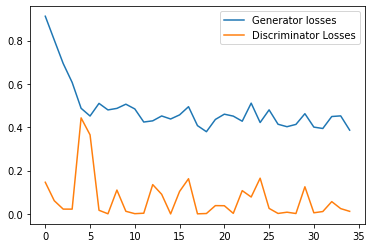

In [ ]:
plt.plot(epoch_arr, gl, label = "Generator losses")
plt.plot(epoch_arr, dl, label = "Discriminator Losses")
plt.legend()
plt.show()

In [ ]:
from scipy.io.wavfile import write

In [ ]:
# final

# final
# final
# final
PP ="/content/drive/MyDrive/output"
def inver_MCCs(mcc_features,sr=22050,dim=36):
  fftlen = pyworld.get_cheaptrick_fft_size(sr)
  decoded_sp=pyworld.decode_spectral_envelope(mcc_features, sr,fftlen) # gives a spectogram
  return decoded_sp

def get_wav_from_spec(f0, decoded_sp,aperiodicity, sr=22050, frame_period=5):
  #get wav file 
  # decoded_sp=inver_MCCs(mcc_features)
  wav = pyworld.synthesize(f0, decoded_sp,aperiodicity, sr, frame_period)
  # Librosa could not save wav if not doing so
  wav = wav.astype(np.float32)
  return wav


import pyworld
from itertools import permutations 
# from tqdm import tqdm
import os
from os import path 
import numpy as np 
file_no=3

with torch.no_grad():
  gen=gen.to("cpu")

  perm = permutations(["VCC2SF1","VCC2SM1","VCC2SF2","VCC2SM2"], 2)
  load_data_path="/content/drive/MyDrive/PREPROCESS_DATA/"
  for i in perm:
    print(i)
    source=load_data_path+i[0]+"/*.npz"
    target=load_data_path+i[1]+"/" #*.npz"
    source=glob(source)
    j=source[file_no]
    file_name=os.path.basename(j)
    if path.exists(target+file_name):
      data=np.load(j)
      f0_s, mcc_features_s, aperiodicity_s=data["f0"],data["mcc_features"],data["aperiodicity"]
      data=np.load(target+file_name)
      f0_t,mcc_t, aperiodicity_t=data["f0"],data["mcc_features"],data["aperiodicity"]
      c=one_hot(i[0],i[1])
      mcc_s=mcc_features_s

      mcc_features_s=torch.Tensor(mcc_features_s)
      # mcc_features_t=torch.Tensor(mcc_features_t)
      mcc_features_s=torch.transpose(mcc_features_s,0,1)
      mcc_features_s=mcc_features_s.view(1,1,36,-1)
      # mcc_features_t=mcc_features_t.view(1,1,36,-1)
      
      c=torch.Tensor(c).view(1,4,4)

      result=gen(mcc_features_s,c).view(36,-1)

      result=torch.transpose(result,0,1)
      result=np.ascontiguousarray(result)
      result=np.double(result)

      print("source")
      wav=get_wav(f0_s,mcc_s,aperiodicity_s)
      play_audio(wav)
      print("target")
      wav=get_wav(f0_t,mcc_t,aperiodicity_t)
      play_audio(wav)
      print("result")
      result=inver_MCCs(result)
      mcc_t=inver_MCCs(mcc_t)
      mcc_s=inver_MCCs(mcc_s)
      # result=result*mcc_t/mcc_s
      result=mcc_s*(mcc_t/result)
      wav=get_wav_from_spec(f0_s,result,aperiodicity_s)
      #print(f0_s)
     # write(PP+"/"+str(i)+".wav", 44100,wav)
      play_audio(wav)



    else:
      print("select some other file no ")


('VCC2SF1', 'VCC2SM1')
source


target


result


('VCC2SF1', 'VCC2SF2')
source


target


result


('VCC2SF1', 'VCC2SM2')
source


target


result


('VCC2SM1', 'VCC2SF1')
source


target


result


('VCC2SM1', 'VCC2SF2')
source


target


result


('VCC2SM1', 'VCC2SM2')
source


target


result


('VCC2SF2', 'VCC2SF1')
source


target


result


('VCC2SF2', 'VCC2SM1')
source


target


result


('VCC2SF2', 'VCC2SM2')
source


target


result


('VCC2SM2', 'VCC2SF1')
source


target


result


('VCC2SM2', 'VCC2SM1')
source


target


result


('VCC2SM2', 'VCC2SF2')
source


target


result


In [ ]:
g=[]
d=[]
epcc=[]
for i in epoch_arr:
   if(i%10)==0:
     g.append(gl[i])
     d.append(dl[i])
     epcc.append(epoch_arr[i])
g



      

[0.9122337102890015,
 0.48431605100631714,
 0.4601188898086548,
 0.400445818901062]

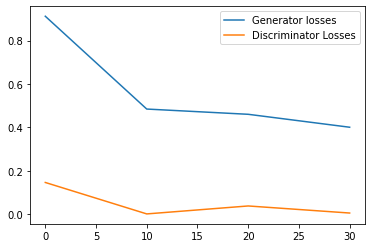

In [ ]:
plt.plot(epcc, g, label = "Generator losses")
plt.plot(epcc, d, label = "Discriminator Losses")
plt.legend()
plt.show()

In [ ]:
result

NameError: ignored